# Plotting the weather data 

- Running in the 24hr environment kernel 
- Functions are built on from 24hr weather script

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pytz

In this project I have converted all the metadata to UTC so should be comparable to the weather data without needing to change timezones

In [5]:
def read_and_process_csv(file_path):
    # Read the CSV file
    df = pd.read_csv(file_path)
    
    # Rename the specified column
    df.rename(columns={'Timestamp (UTC+0)': 'date_time'}, inplace=True)
    
    # Convert the date column to datetime format
    df['date_time'] = pd.to_datetime(df['date_time'])
    
    return df

# Run the function for all the data
ten_min_23 = read_and_process_csv('../metadata/2023/10min_Oct22_Aug23_weather.csv')
daily_23 = read_and_process_csv('../metadata/2023/Daily_Oct22_Aug23_weather.csv')
hourly_23 = read_and_process_csv('../metadata/2023/Hourly_Oct22_Aug23_weather.csv')

ten_min_24 = read_and_process_csv('../metadata/2024/10_min.csv')
hourly_24 = read_and_process_csv('../metadata/2024/Hourly.csv')
daily_24 = read_and_process_csv('../metadata/2024/Daily.csv')

#Concatenate the different years
ten_min = pd.concat([ten_min_23, ten_min_24])
hourly = pd.concat([hourly_23, hourly_24])
daily = pd.concat([daily_23, daily_24])

# Convert the date columns to datetime format with error handling
daily['AirTC_TMn'] = pd.to_datetime(daily['AirTC_TMn'], errors='coerce', format='%d/%m/%Y %H:%M')
daily['AirTC_TMx'] = pd.to_datetime(daily['AirTC_TMx'], errors='coerce', format='%d/%m/%Y %H:%M')

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_26365/1416644188.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_26365/1416644188.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_26365/1416644188.py:9: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['date_time'] = pd.to_datetime(df['date_time'])


### Read in collections and filter the data
- Also want to read in a dataframe that provides the start and end times of the different experiments 
    - all_2023 (whole collection time period)
    - all_2024 (collected weekly the whole time)
    - weekly_2023 (just the time period when weekly samples were collected)
- Can add other start and end times to this if I am interested
- this means I am getting specific start and end dates, which I could elongate as I did download more info

In [31]:
#Start & End times from different experiments - recorded as BST
collections = pd.read_csv('../metadata/collections.csv')
collections['Start'] = pd.to_datetime(collections['Start'], format='%Y-%m-%d %H:%M:%S')
collections['End'] = pd.to_datetime(collections['End'], format='%Y-%m-%d %H:%M:%S')

In [32]:
# Filter the data by start and end times
def filter_data_by_collection(data, collections):
    # Dictionary to store the filtered DataFrames
    filtered_dfs = {}

    # Iterate over each row in the collection DataFrame
    for _, row in collections.iterrows():
        # Filter the data DataFrame to include only the timestamps within the specified range
        filtered = data[(data['date_time'] >= row['Start']) & (data['date_time'] <= row['End'])]
        
        # Store the filtered DataFrame in the dictionary with the collection name as the key
        filtered_dfs[row['Experiment']] = filtered

    return filtered_dfs

# Filter the datasets by collection periods
ten_min_filtered = filter_data_by_collection(ten_min, collections)
hourly_filtered = filter_data_by_collection(hourly, collections)
daily_filtered = filter_data_by_collection(daily, collections) 

# Can access each filtered DataFrame using the collection name e.g.
# daily_filtered['all_2023']

## Daily plot

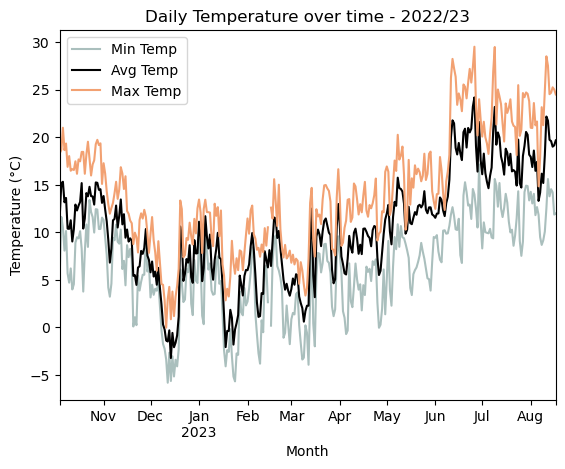

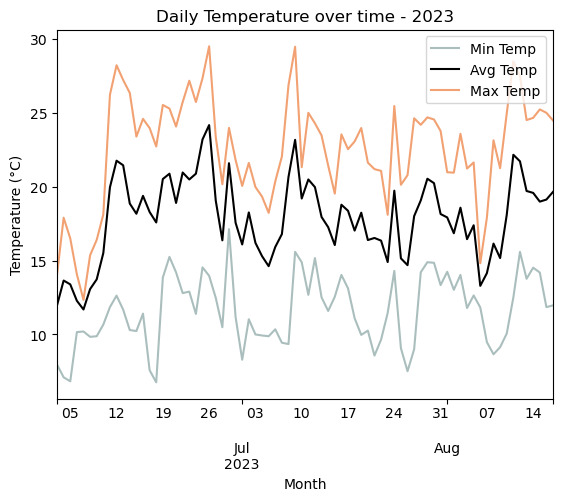

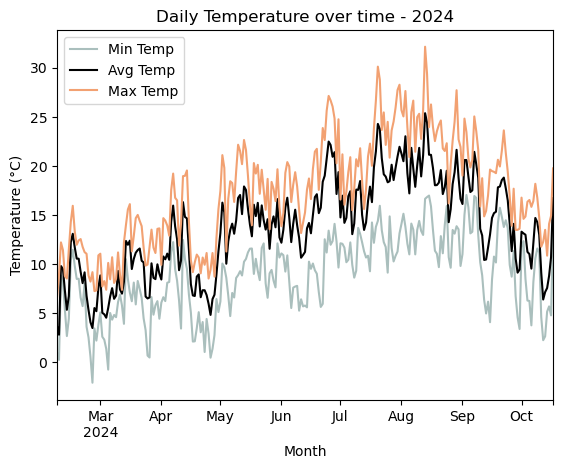

In [ ]:
def plot_daily_temperature(experiment, year, title_ending):
    # Plot the data
    w = daily_filtered[experiment].plot(x='date_time',
                                        y=['Min_AirTC', 'PTemp_C_Avg', 'Max_AirTC'],
                                        kind='line',
                                        color=['#AABFBD', 'black', '#F2A172'],
                                        label=['Min Temp', 'Avg Temp', 'Max Temp'])

    w.set_xlabel('Month')
    w.set_ylabel('Temperature (°C)')
    w.tick_params(axis='x', which='minor', bottom=False)
    plt.title(f'Daily Temperature over time - {title_ending}')
    plt.savefig(f'../Graphs/Weather/daily_temp_min_max_{experiment}.png')
    plt.show()

# Run the function
plot_daily_temperature('all_2023', 2023, '2022/23')
plot_daily_temperature('weekly_2023', 2023, '2023')
plot_daily_temperature('all_2024', 2024, '2024')


## Hourly plots

Plotting the average of each day with SE because otherwise it's too much data over so many months. 

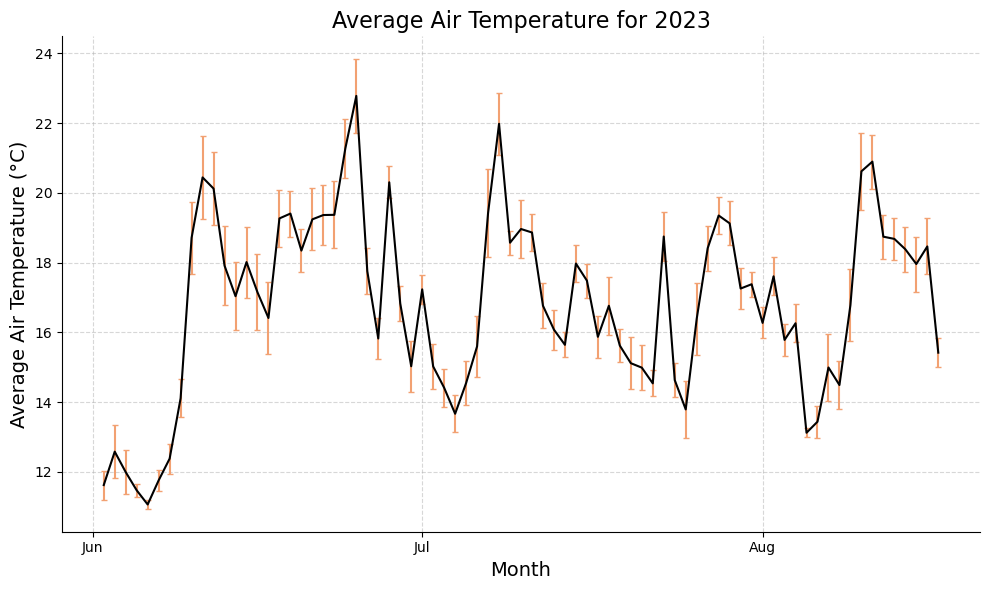

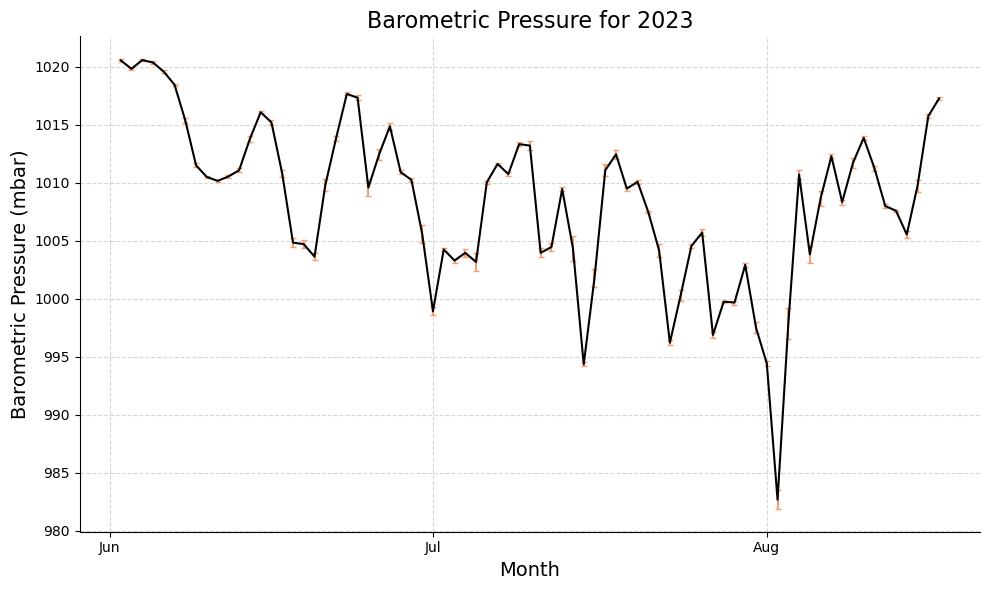

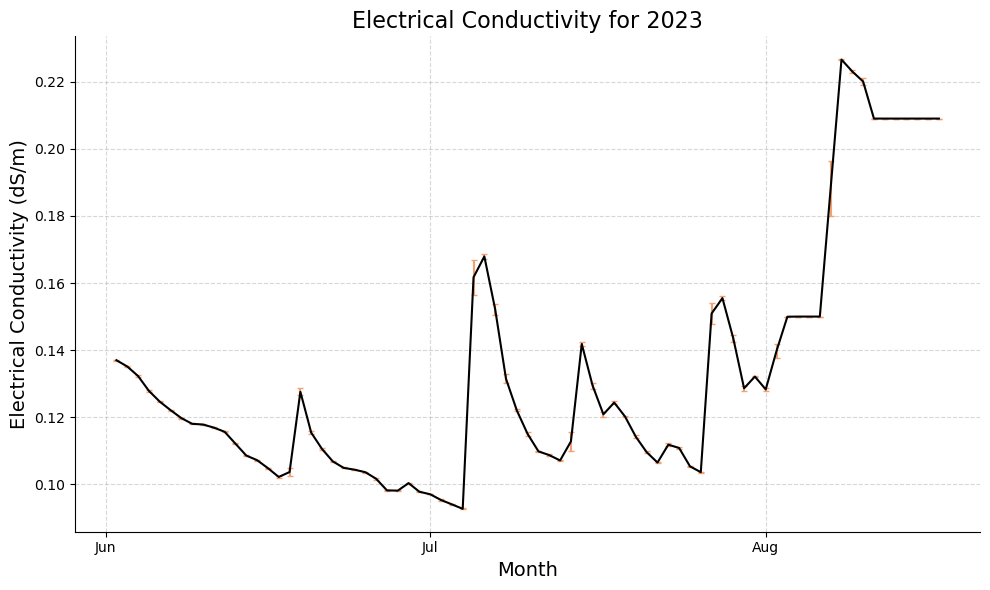

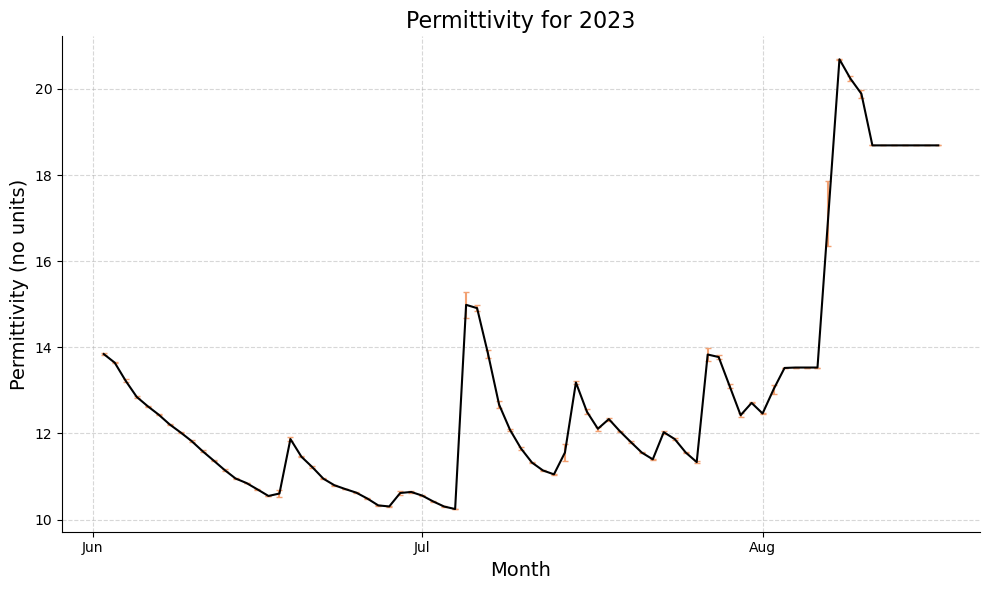

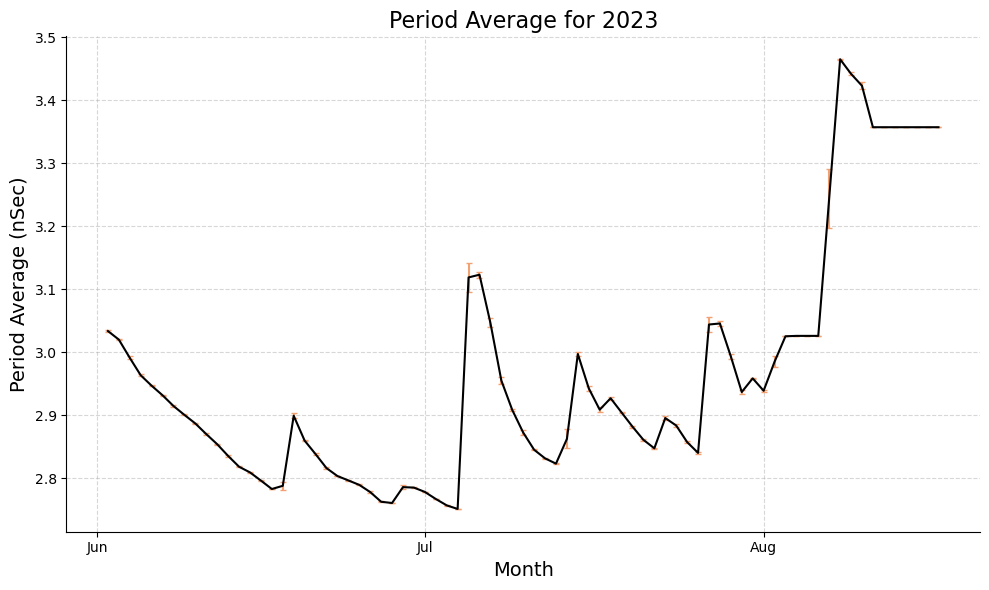

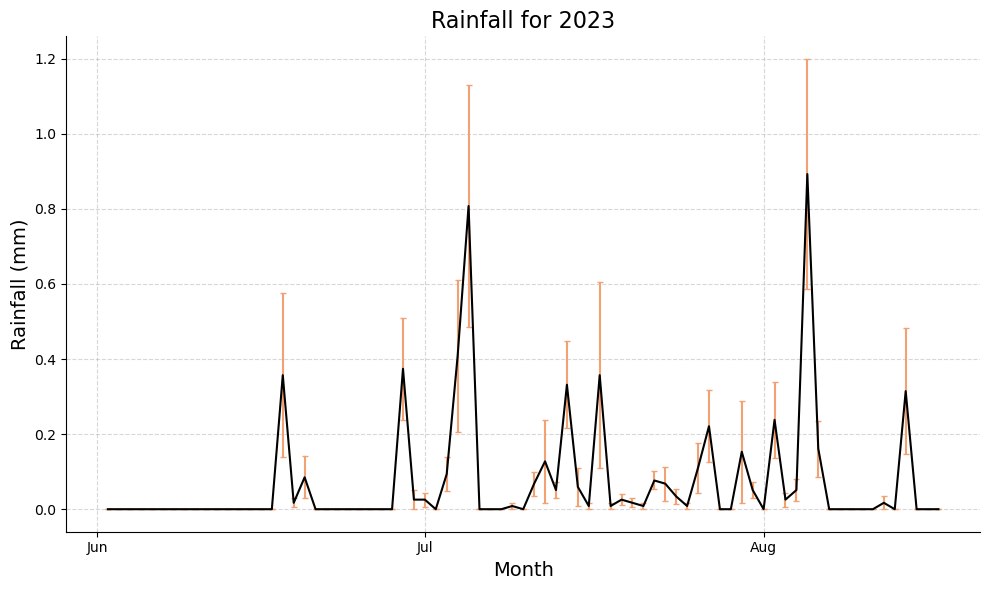

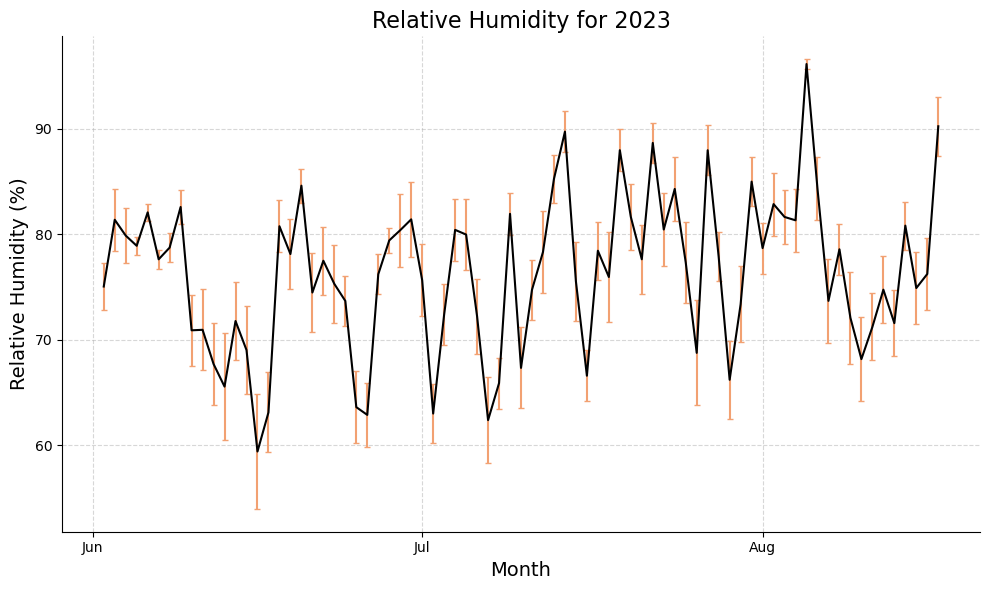

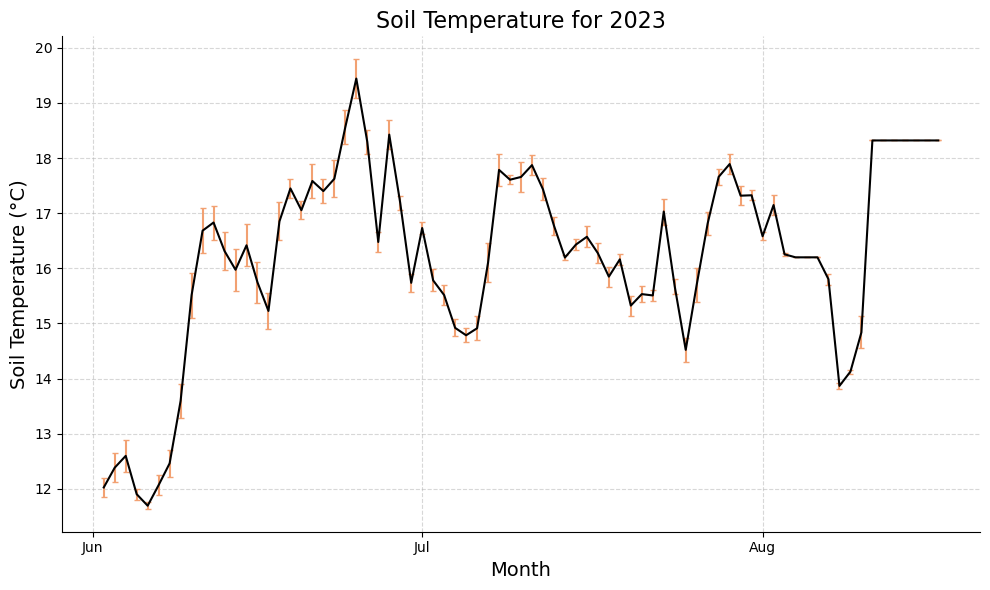

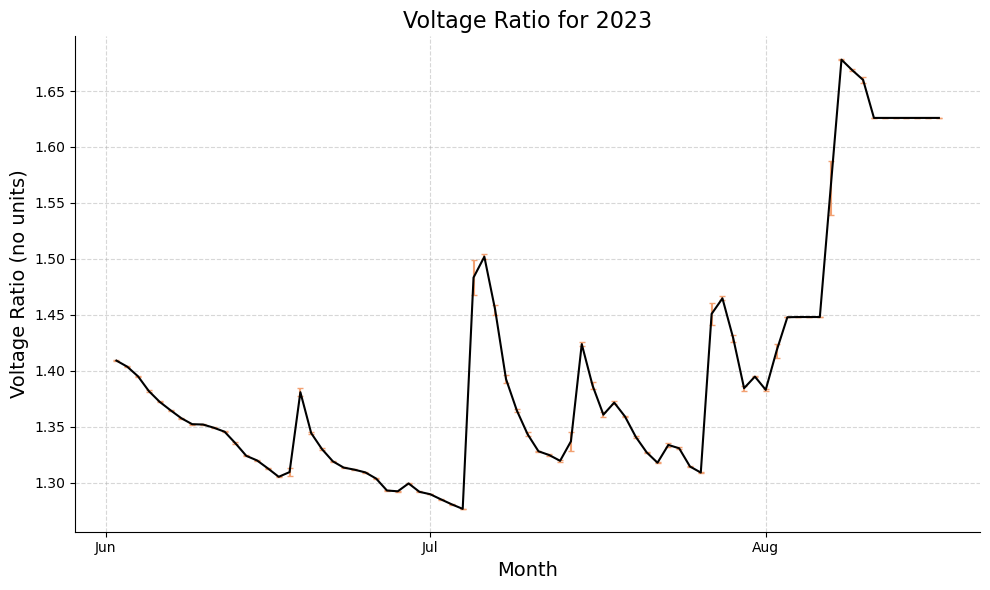

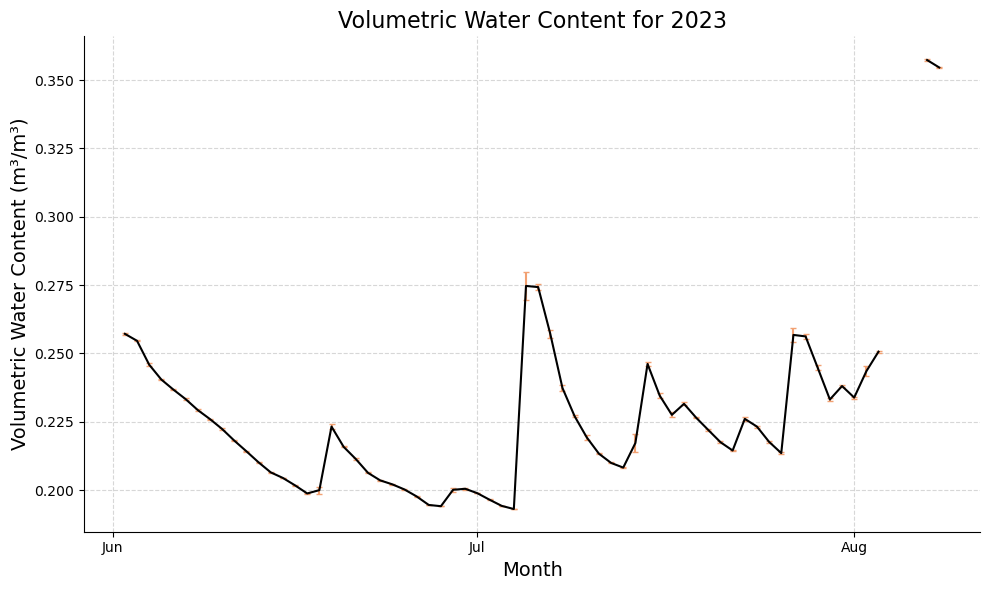

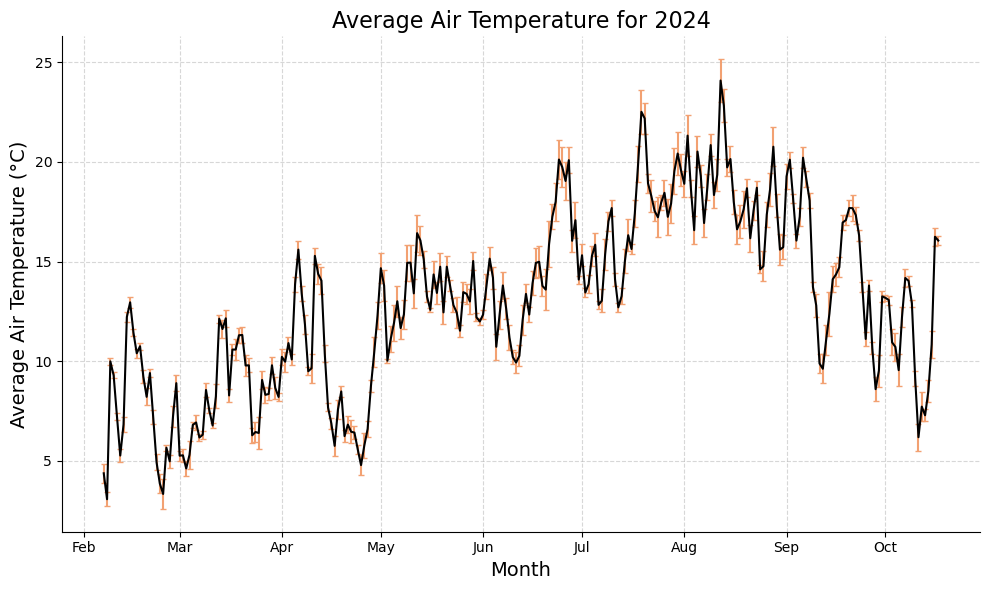

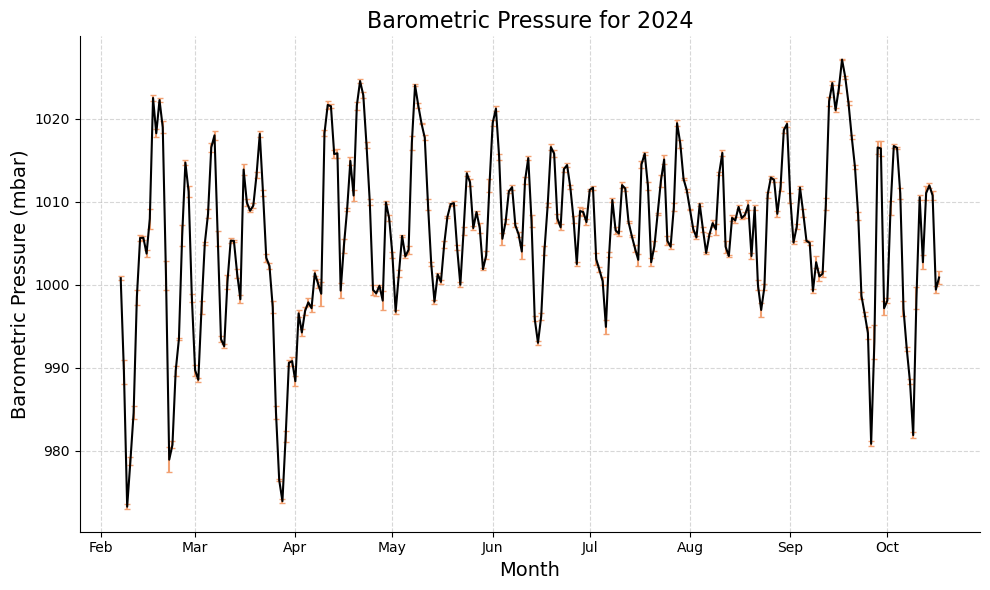

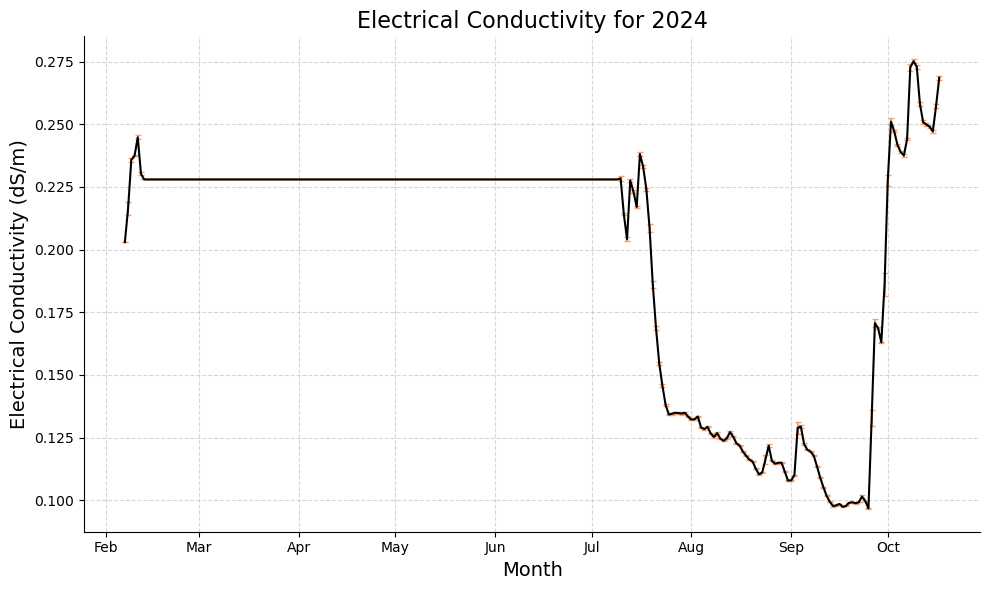

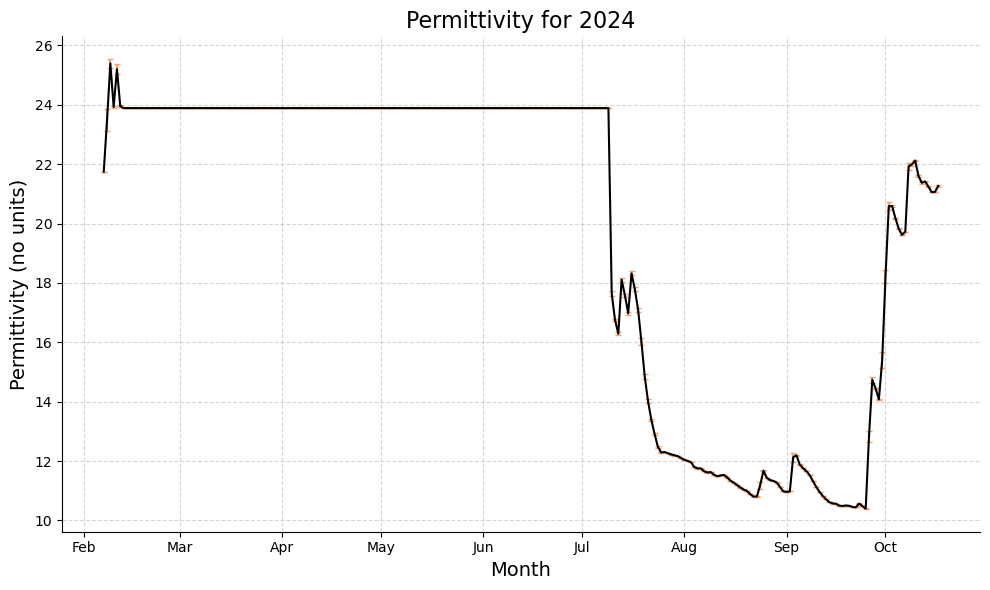

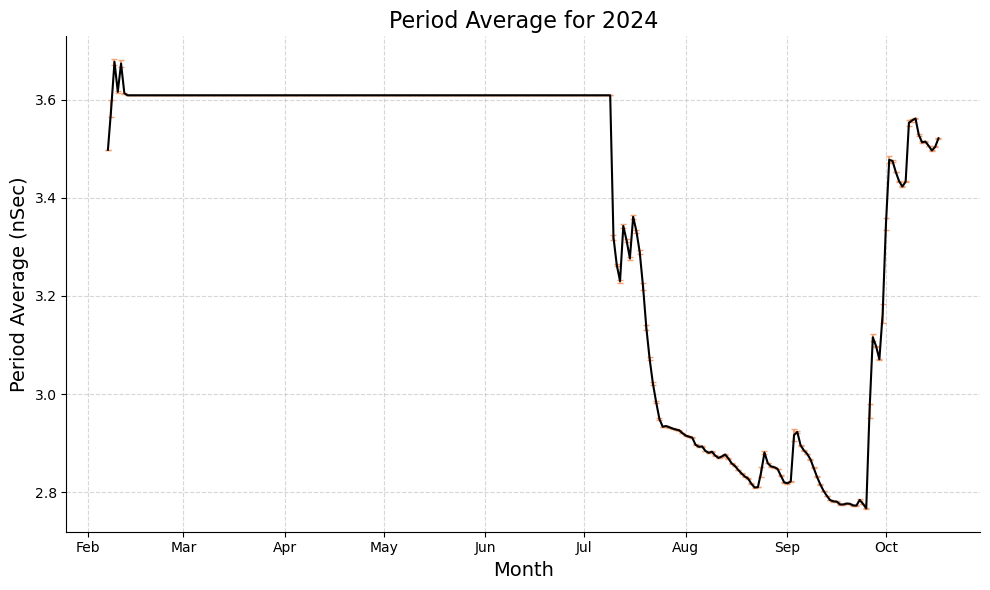

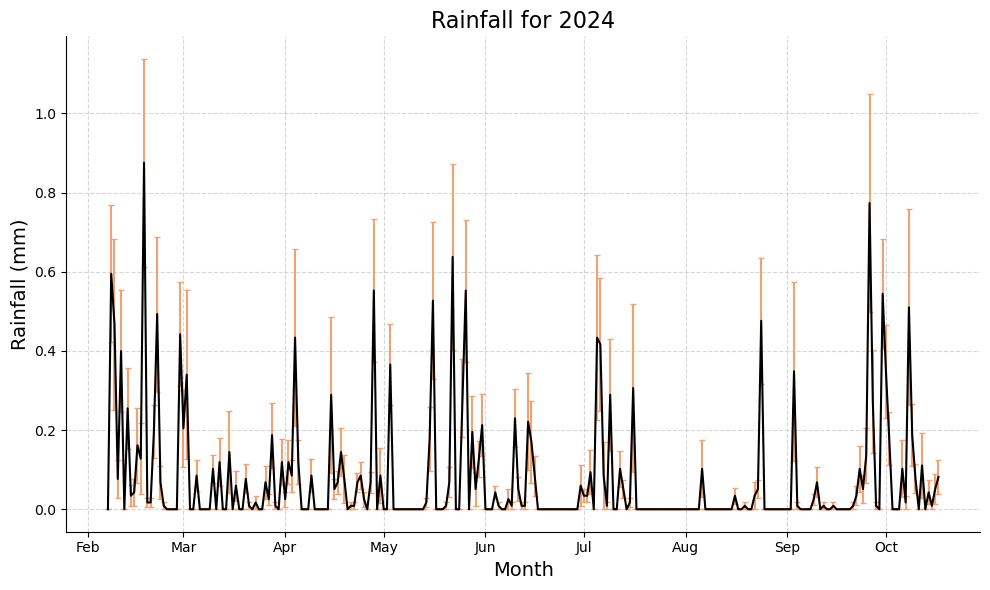

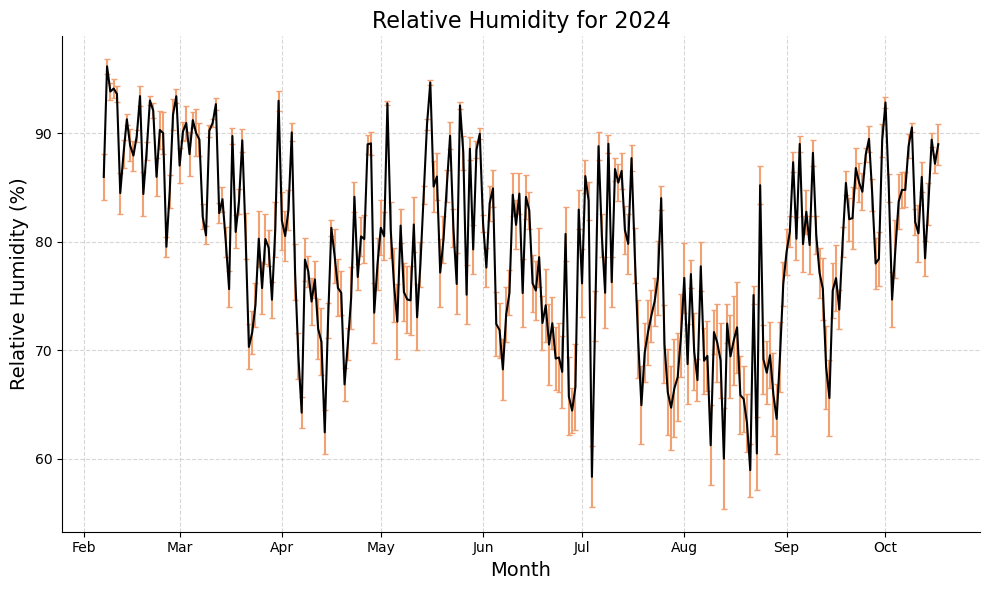

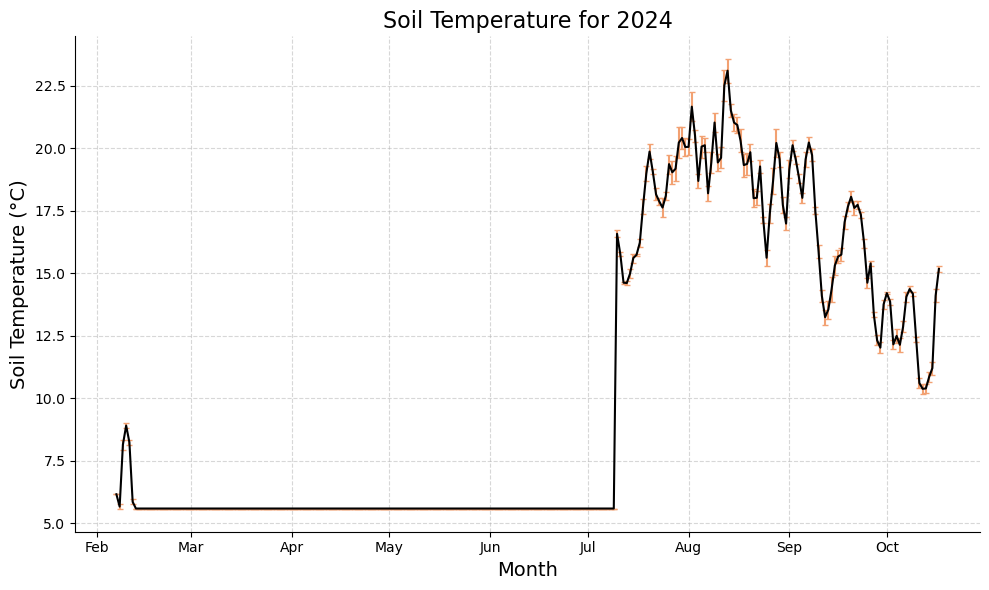

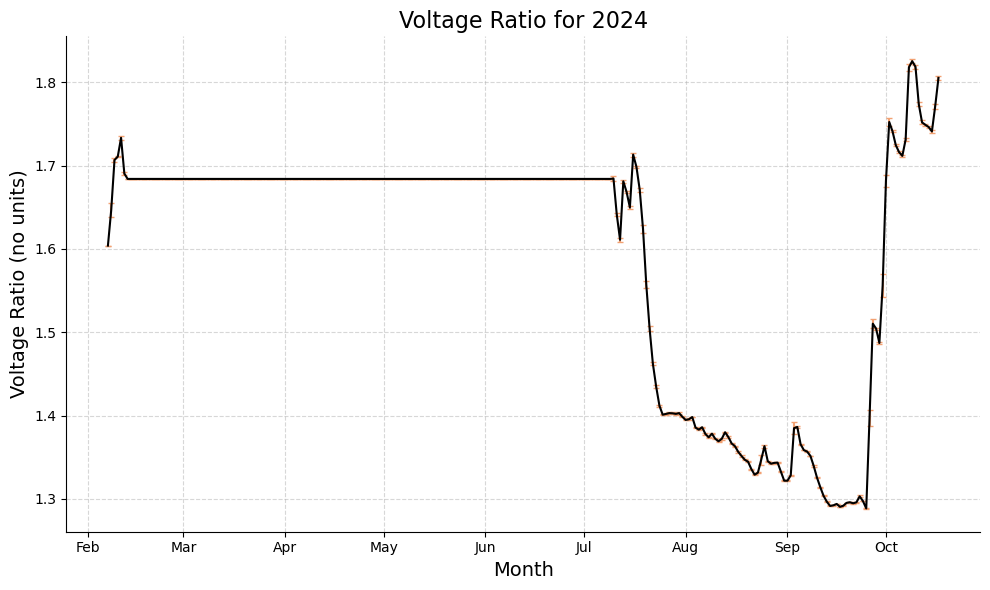

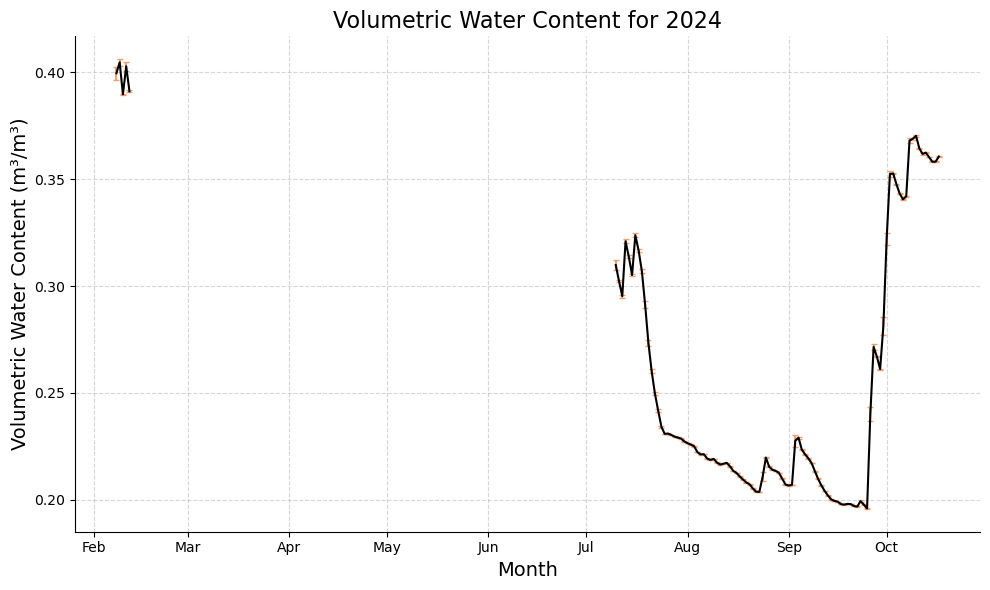

In [ ]:
def plot_hourly_data(experiment, plot_title):
    hourly = hourly_filtered[experiment]

    hourly['Date'] = hourly['date_time'].dt.date  # add a column for date
    hourly['Date'] = pd.to_datetime(hourly['Date'])

    # Specify the columns you don't want to include in the aggregation
    columns_to_exclude = ['Date', 'date_time']

    # Get the list of columns you want to include in the aggregation
    columns_to_include = [col for col in hourly.columns if col not in columns_to_exclude]

    # Perform the aggregation on the selected columns
    group_hour = hourly.groupby('Date')[columns_to_include].agg(['mean', 'sem'])

    # Create a figure and axis object for each variable
    for variable in group_hour.columns.levels[0]:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the standard error as error bars
        ax.errorbar(group_hour.index, group_hour[(variable, 'mean')], yerr=group_hour[(variable, 'sem')], fmt='none', ecolor='#F2A172', capsize=2, label='SE')

        # Plot the mean line
        ax.plot(group_hour.index, group_hour[(variable, 'mean')], linestyle='-', markersize=5, label=variable, color='black')

        # Format the x-axis to display dates nicely
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

        # Nice labels
        if variable == 'AirTC_Avg':
            ylabel = 'Average Air Temperature (°C)'
            title = f'Average Air Temperature'
        elif variable == 'RH':
            ylabel = 'Relative Humidity (%)'
            title = f'Relative Humidity'
        elif variable == 'VWC_Avg':
            ylabel = 'Volumetric Water Content (m³/m³)'
            title = f'Volumetric Water Content'
        elif variable == 'EC_Avg':
            ylabel = 'Electrical Conductivity (dS/m)'
            title = f'Electrical Conductivity'
        elif variable == 'T_Avg':
            ylabel = 'Soil Temperature (°C)'
            title = f'Soil Temperature'
        elif variable == 'P_Avg':
            ylabel = 'Permittivity (no units)'
            title = f'Permittivity'
        elif variable == 'PA_Avg':
            ylabel = 'Period Average (nSec)'
            title = f'Period Average'
        elif variable == 'VR_Avg':
            ylabel = 'Voltage Ratio (no units)'
            title = f'Voltage Ratio'
        elif variable == 'Rain_mm_Tot':
            ylabel = 'Rainfall (mm)'
            title = f'Rainfall'
        elif variable == 'BP_mbar_Avg':
            ylabel = 'Barometric Pressure (mbar)'
            title = f'Barometric Pressure'
        else:
            ylabel = 'Value'
            title = f'{variable} Plot - {experiment}'

        # Set labels and title
        ax.set_xlabel('Month', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.set_title(f'{title} {plot_title}', fontsize=16)

        # Add legend
        # ax.legend(fontsize=12)

        # Set grid
        ax.grid(True, linestyle='--', alpha=0.5)

        # Remove the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Show plot
        plt.tight_layout()
        plt.savefig(f'../Graphs/Weather/hourly/hourly_{variable}_{experiment}.png')

# For the data
plot_hourly_data('all_2023', 'for 2022 - 2023')
plot_hourly_data('weekly_2023', 'for 2023')
plot_hourly_data('all_2024', 'for 2024')

## Look into the 10 minute data 

Currently also plotting daiy average of the 10 min data, which I think makes sense when looking over a year

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_26365/1856190613.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min['Date'] = ten_min['date_time'].dt.date  # add a column for date
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_26365/1856190613.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min['Date'] = pd.to_datetime(ten_min['Date'])


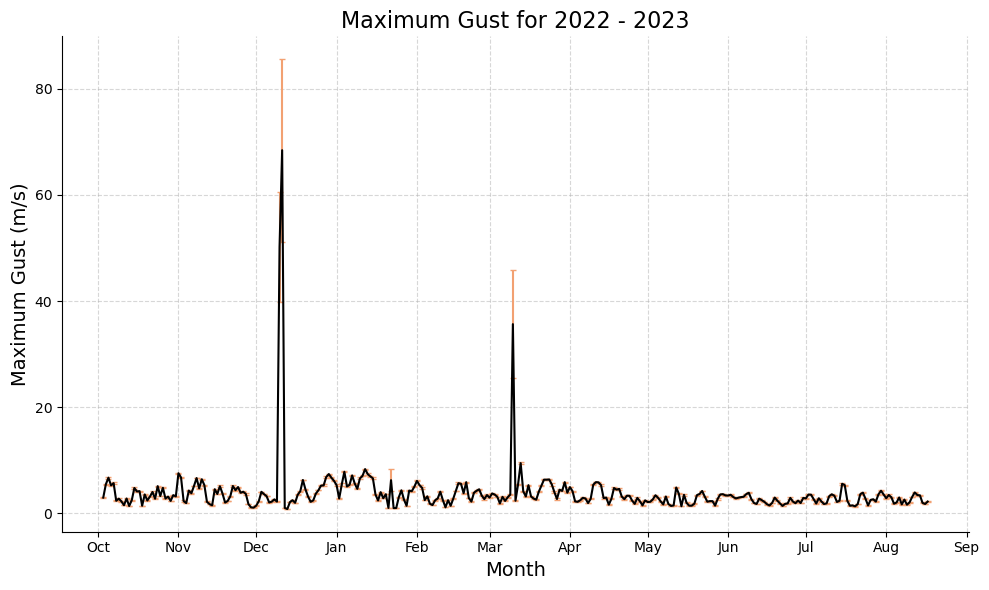

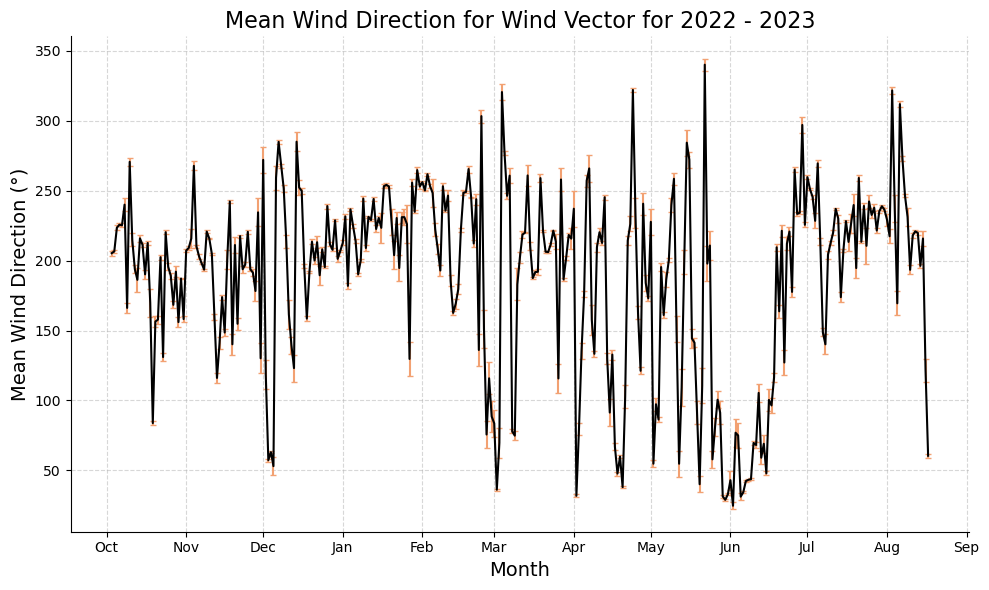

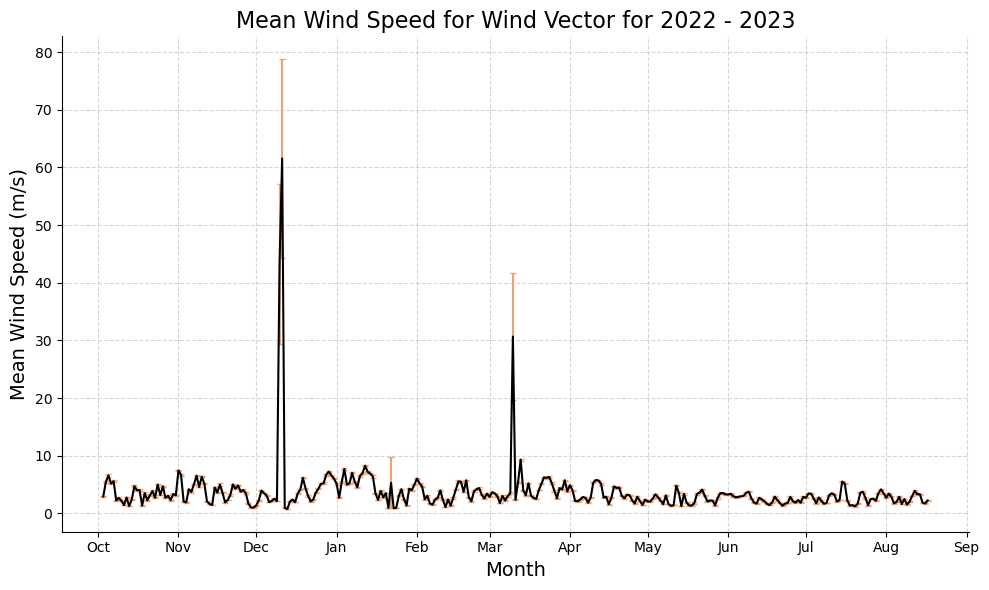

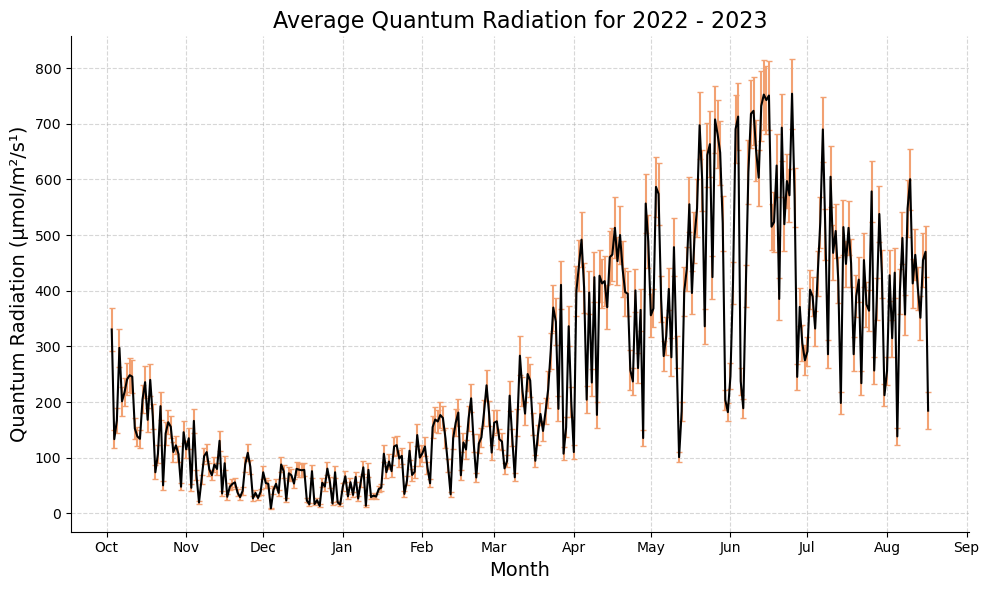

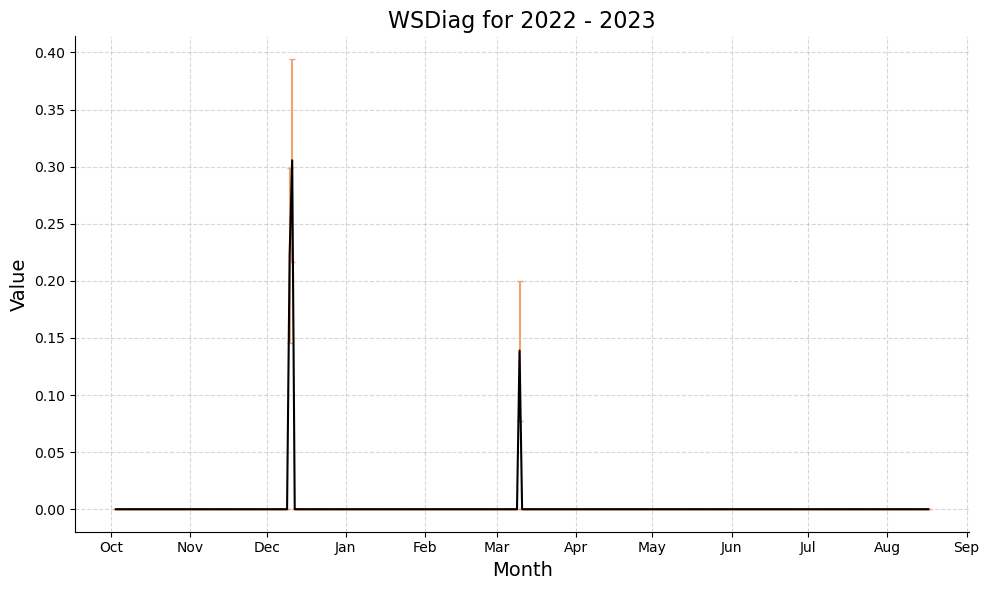

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_26365/1856190613.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min['Date'] = ten_min['date_time'].dt.date  # add a column for date
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_26365/1856190613.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min['Date'] = pd.to_datetime(ten_min['Date'])


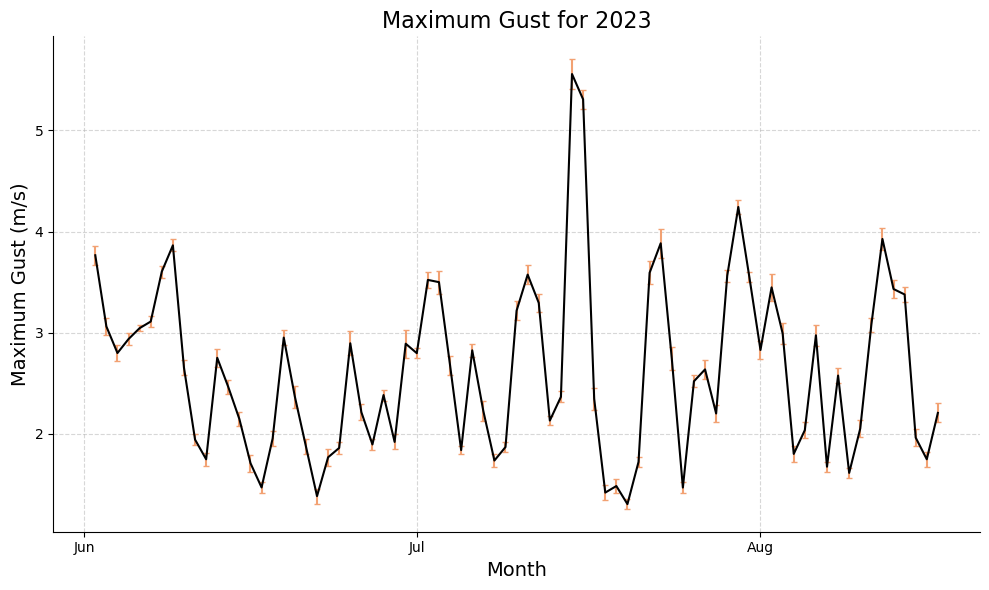

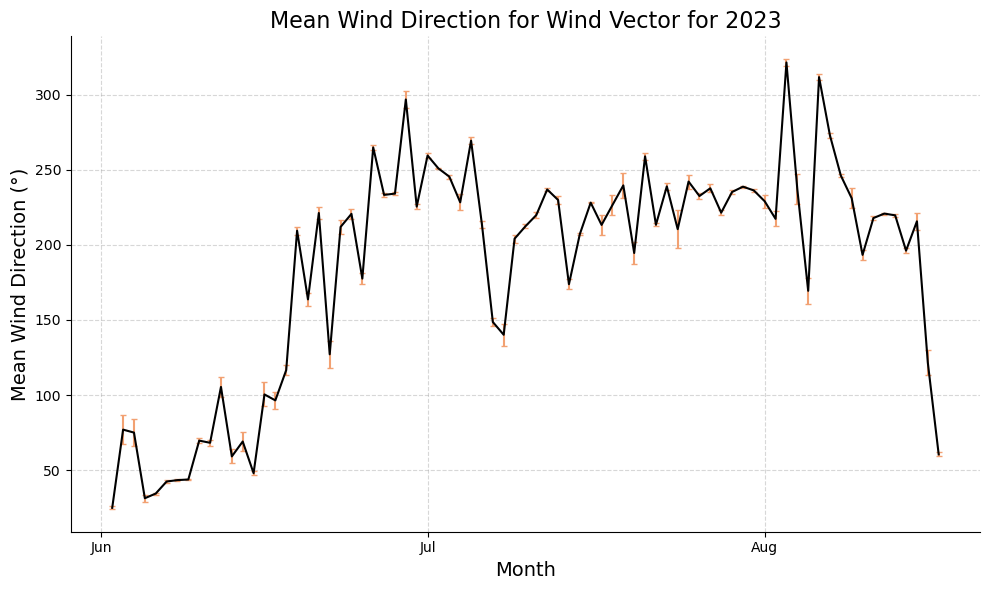

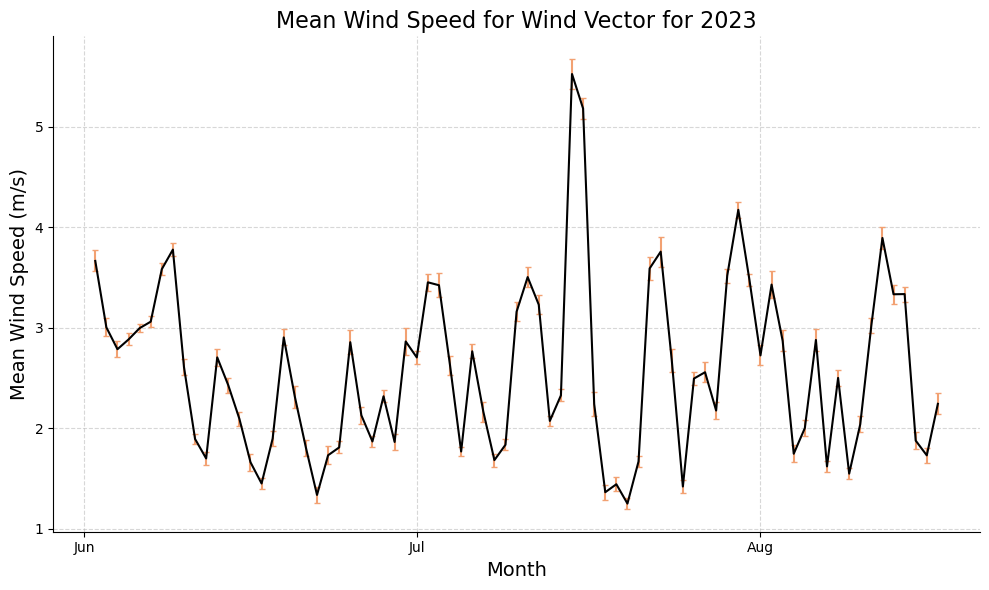

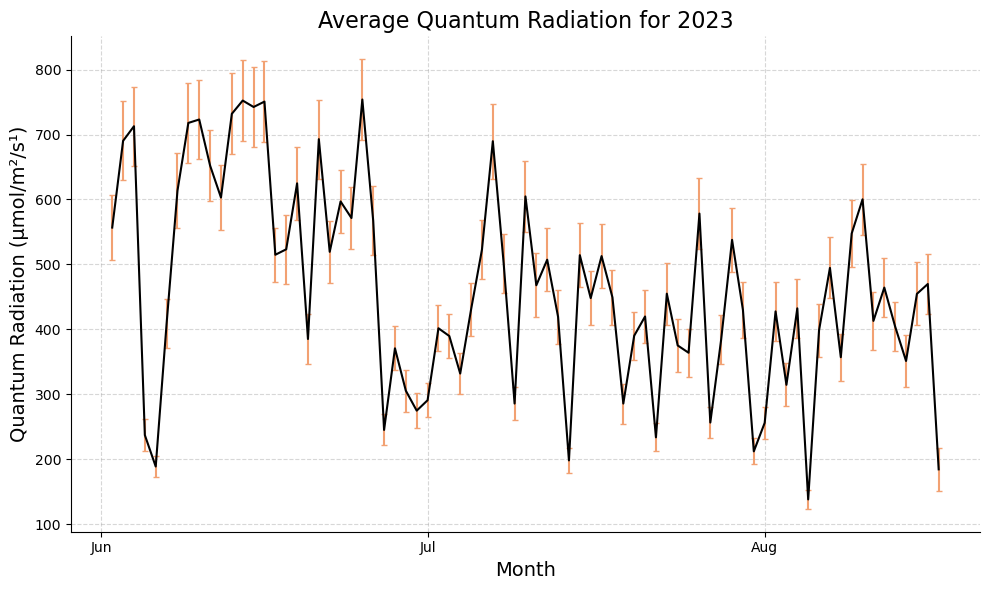

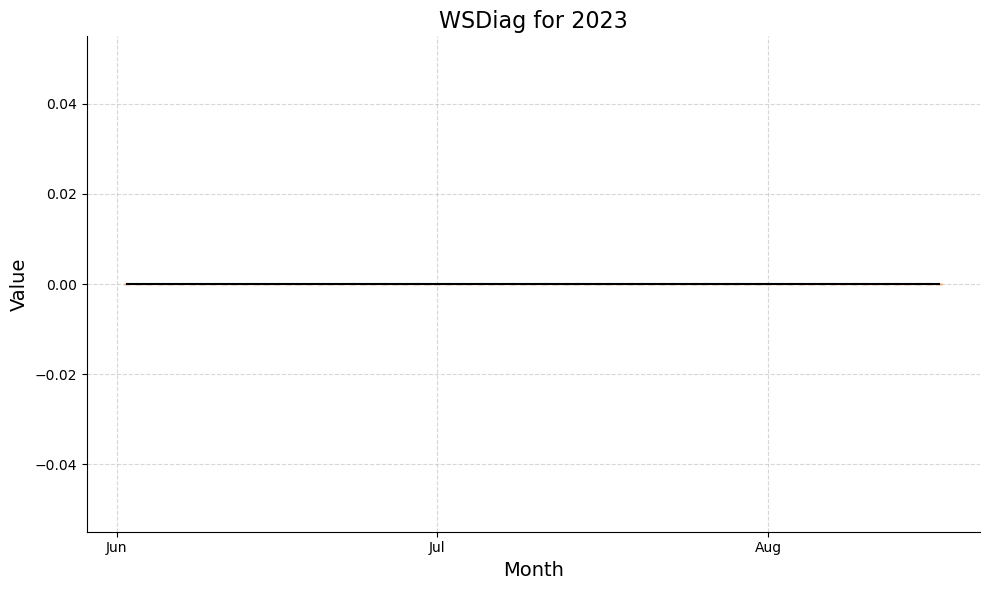

/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_26365/1856190613.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min['Date'] = ten_min['date_time'].dt.date  # add a column for date
/var/folders/ns/9skdzql508n7rzzgbqpc2wpw000f7r/T/ipykernel_26365/1856190613.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ten_min['Date'] = pd.to_datetime(ten_min['Date'])


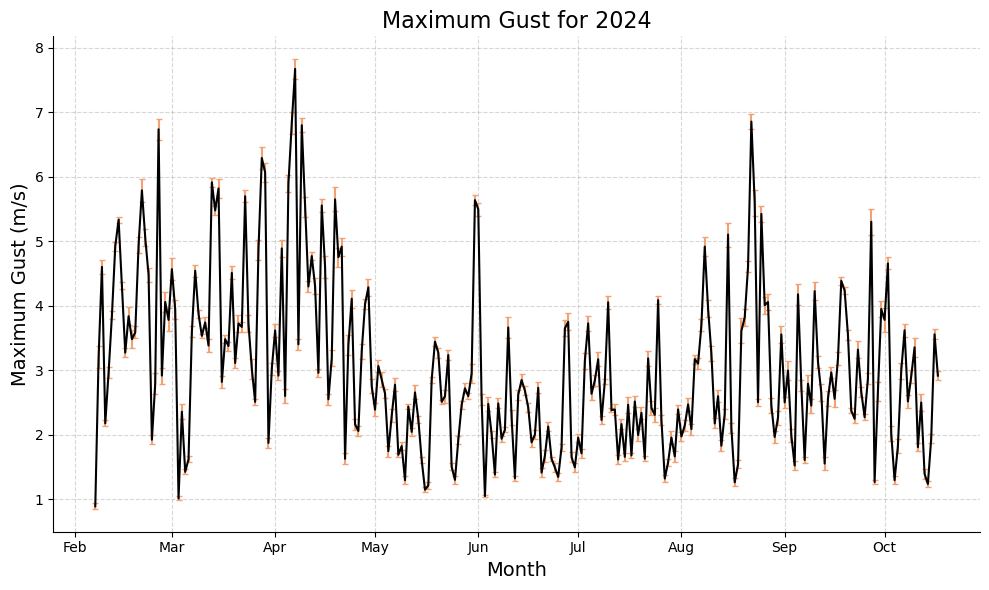

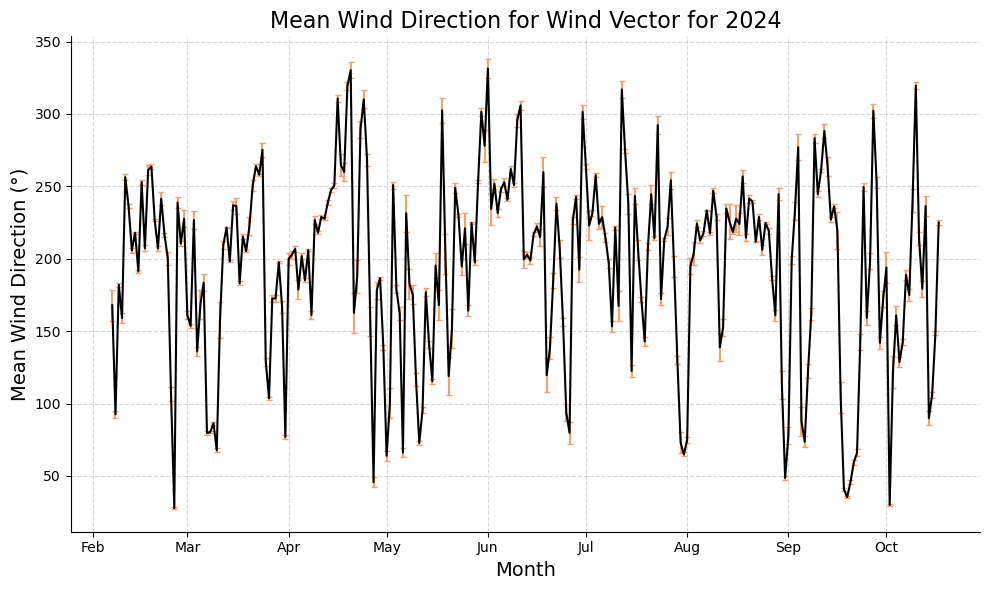

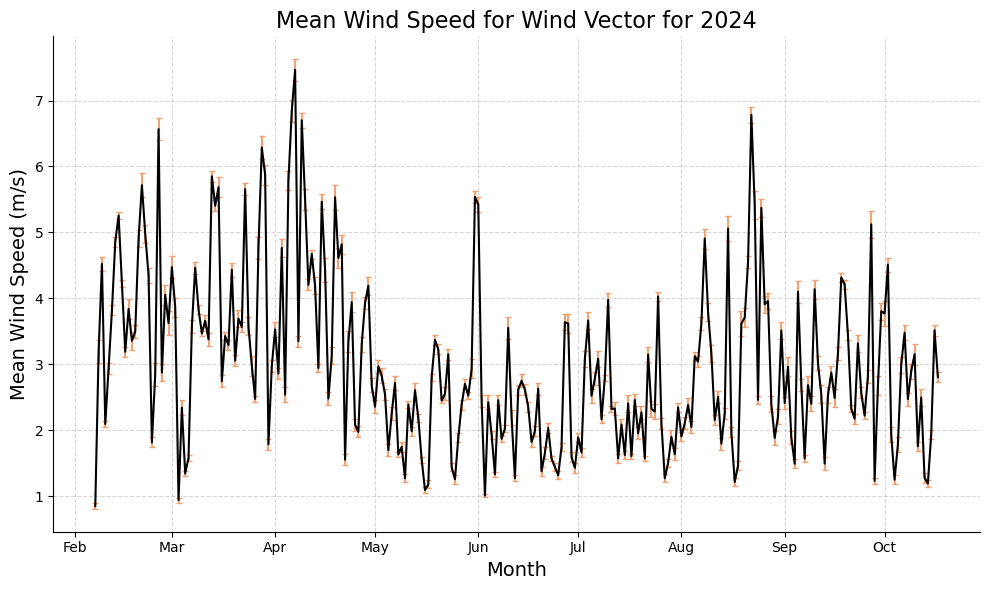

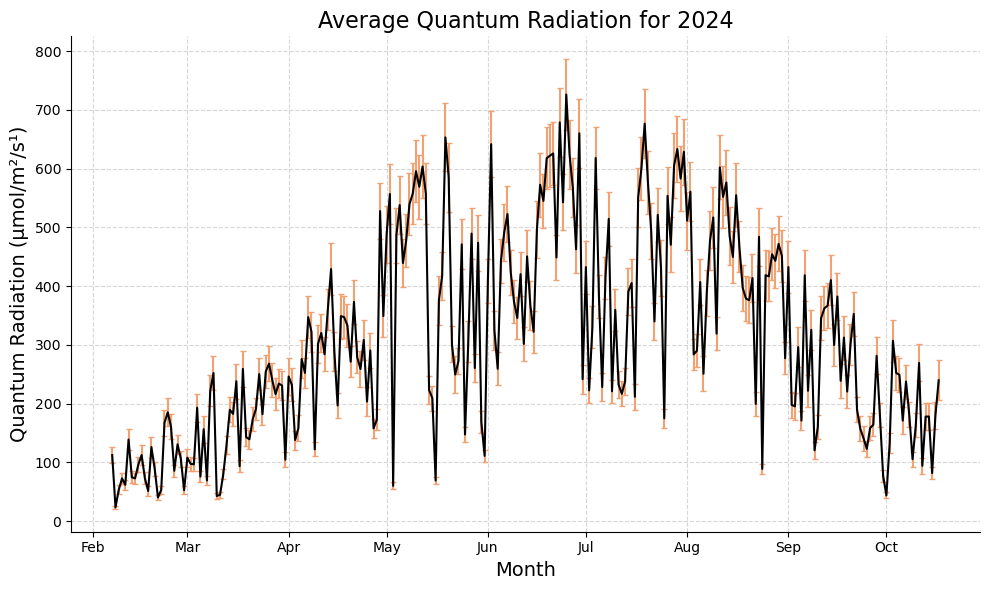

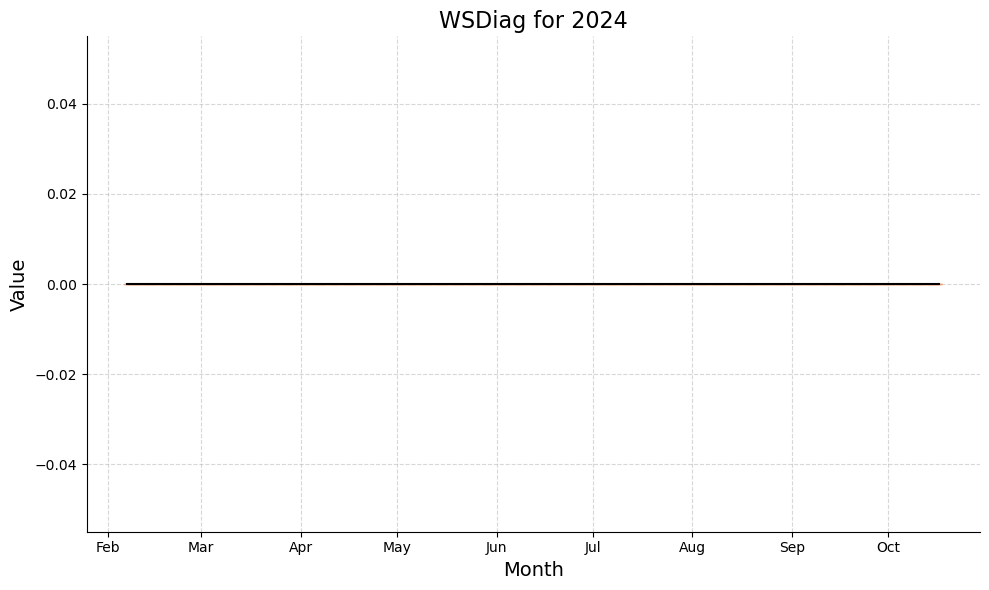

In [57]:
def plot_ten_min_data(experiment, plot_title):
    ten_min = ten_min_filtered[experiment]

    ten_min['Date'] = ten_min['date_time'].dt.date  # add a column for date
    ten_min['Date'] = pd.to_datetime(ten_min['Date'])

    # Specify the columns you don't want to include in the aggregation
    columns_to_exclude = ['Date', 'date_time']

    # Get the list of columns you want to include in the aggregation
    columns_to_include = [col for col in ten_min.columns if col not in columns_to_exclude]

    # Perform the aggregation on the selected columns
    group_min = ten_min.groupby('Date')[columns_to_include].agg(['mean', 'sem'])

    # Get the first level of the column names
    variables = group_min.columns.get_level_values(0).unique()

    # Create a figure and axis object for each variable
    for variable in variables:
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot the standard error as error bars
        ax.errorbar(group_min.index, group_min[(variable, 'mean')], yerr=group_min[(variable, 'sem')], fmt='none', ecolor='#F2A172', capsize=2, label='SE')

        # Plot the mean line
        ax.plot(group_min.index, group_min[(variable, 'mean')], linestyle='-', markersize=5, label=variable, color='black')

        # Format the x-axis to display dates nicely
        ax.xaxis.set_major_locator(mdates.MonthLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))

        # Nice labels
        if variable == 'QR_Avg':
            ylabel = 'Quantum Radiation (μmol/m²/s¹)'
            title = f'Average Quantum Radiation'
        elif variable == 'Mean_WS':
            ylabel = 'Mean Wind Speed (m/s)'
            title = f'Mean Wind Speed for Wind Vector'
        elif variable == 'Mean_WD':
            ylabel = 'Mean Wind Direction (°)'
            title = f'Mean Wind Direction for Wind Vector'
        elif variable == 'Gust_Max':
            ylabel = 'Maximum Gust (m/s)'
            title = f'Maximum Gust'
        else:
            ylabel = 'Value'
            title = f'{variable}'

        # Set labels and title
        ax.set_xlabel('Month', fontsize=14)
        ax.set_ylabel(ylabel, fontsize=14)
        ax.set_title(f'{title} {plot_title}', fontsize=16)

        # Set grid
        ax.grid(True, linestyle='--', alpha=0.5)

        # Remove the top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Show plot
        plt.tight_layout()
        plt.savefig(f'../Graphs/Weather/ten_min/ten_min_{variable}_{experiment}.png')
        plt.show()

# Run the function
plot_ten_min_data('all_2023', 'for 2022 - 2023')
plot_ten_min_data('weekly_2023', 'for 2023')
plot_ten_min_data('all_2024', 'for 2024')


In [ ]:
metadata.columns

Index(['Sample_ID', 'Sampler_Used', 'Notes', 'Location', 'Year', 'BST_GMT',
       'Date_Collected', 'Missing_Date', 'Missing_Time', 'Start_Time',
       'End_Time', 'Collection_Length_Min', ' DNA_Concentration_(ng/ul)',
       'WGA', ' DNA_Concentration_WGA_(ng/ul)', 'Location_96_well_plate',
       'Barcode', 'DateTime_UTC'],
      dtype='object')